In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
%autoreload 2
from datetime import datetime
import matplotlib.pyplot as plt
from neural_analysis import spectra
import numpy as np
import sys
from tqdm.autonotebook import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import save, load

### 1) Initialize Parameters

In [20]:
T = 125 # s, duration of time series
dt = 0.02 # s, time step
D_r = 300 # number of reservoir nodes
d = 6 # average degree of Erdos-Renyi network
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0 # regularization parameter
# beta = 1e-4 # regularization parameter
sigma = 0.1 # maximum value of the input weights

squared_inds = None
# squared_inds = np.random.choice(np.arange(D_r), size=(int(D_r/2),), replace=False)

var_names = ['x', 'y', 'z']

# initial_condition = None 
# initial_condition = (-8, -7, 29)
initial_condition = (-8.01304744, -6.58865759, 28.60202532)

### 2) Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\rho = 28$, $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [21]:
lorenz_pts = simulate_lorenz(dt=dt, T=T, initial_condition=initial_condition)

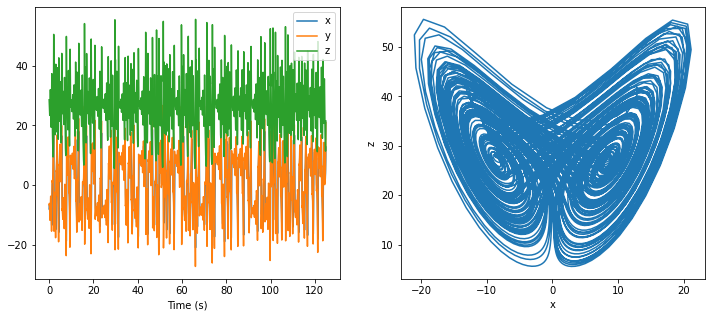

In [22]:
time_vals = np.arange(len(lorenz_pts))*dt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

### Build the Network

In [23]:
reservoir = ReservoirDS(lorenz_pts, dt=dt, D_r=D_r, d=d, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)

The average degree of the network is 6.00


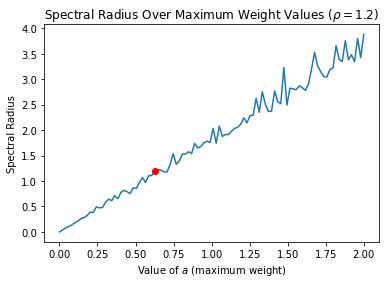

The spectral radius is 1.204


In [24]:
reservoir.build_connectivity(debug=True)

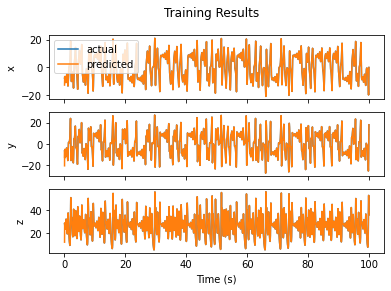

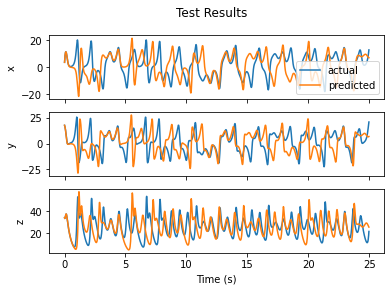

In [25]:
reservoir.train_and_test(debug=True)

In [26]:
# POWER SPECTRAL DENSITY

In [27]:
power_spectra = []
for i in range(reservoir.D):
    spec_true, freqs_true = spectra.spectrum(reservoir.u[reservoir.num_steps_train:, i], smp_rate=1/reservoir.dt, spec_type='power', freq_range=[0, 80])
    spec_test, freqs_test = spectra.spectrum(reservoir.v_test[:, i], smp_rate=1/reservoir.dt, spec_type='power', freq_range=[0, 80])
    power_spectra.append({'true': {'spec': spec_true, 'freqs': freqs_true}, 'test': {'spec': spec_test, 'freqs': freqs_test}, 'mse': ((spec_test - spec_true)**2).mean()})

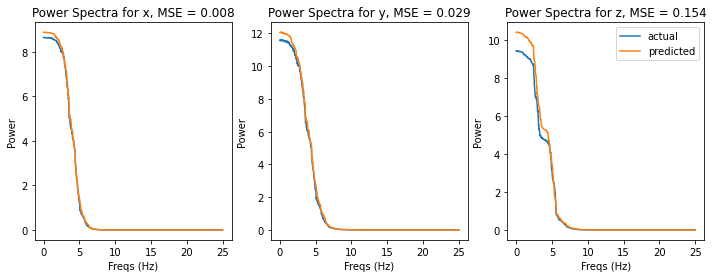

In [28]:
plt.figure(figsize=(12, 4))
for i in range(reservoir.D):
    plt.subplot(1, 3, i+1)
    plt.plot(power_spectra[i]['true']['freqs'], power_spectra[i]['true']['spec'], label='actual')
    plt.plot(power_spectra[i]['test']['freqs'], power_spectra[i]['test']['spec'], label='predicted')
    plt.title(f"Power Spectra for {reservoir.var_names[i]}, MSE = {power_spectra[i]['mse']:.3f}")
    plt.xlabel('Freqs (Hz)')
    plt.ylabel('Power')
plt.legend()
plt.show()

In [29]:
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
save(reservoir, f'../../__data__/reservoir {timestamp}.pkl')

In [30]:
# loading_filepath = "/Users/adameisen/Documents/MIT/2021 Summer/ChaoticConsciousness/__data__/reservoir 2021-06-08 15:04:05.pkl"
# reservoir2 = load(loading_filepath)

## Jacobian

In [31]:
def sech(x):
    return 1/np.cosh(x)

def jacobian(reservoir):
    J = np.zeros((reservoir.num_steps_test, reservoir.D_r, reservoir.D_r))
    
    # 0th step
#     D_mat = np.diag(sech(reservoir.A@reservoir.r_train[-1] + reservoir.W_in @ reservoir.v_train[-1])**2)
    D_mat = np.diag(sech(reservoir.A@reservoir.r_train[-1] + reservoir.W_in @ reservoir.v_train[-1])**2)
    J[0] = D_mat @ reservoir.A
    
    for t in range(reservoir.num_steps_test - 1):
        D_mat = np.diag(sech(reservoir.A @ reservoir.r_test[t] + reservoir.W_in @ reservoir.v_test[t])**2)
        J[t+1] = D_mat @ reservoir.A
        
    return J

In [32]:
J = jacobian(reservoir)

In [33]:
def lyap_spectrum_QR(Js,T):
    K,n = Js.shape[0],Js.shape[-1]    
    Q,R = np.linalg.qr(Js[0])
    lyaps = np.zeros((n,))

    for t in range(1,K):
        Q = Js[t] @ Q
        

        # Need diagonal of R to be positive, so rewrite Q = Q @ S and R = S @ R, where S_ii = sign(R_ii)
        S = np.diag(np.sign(np.diag(R)))
#         print(np.diag(S@R))
        lyaps += np.log(np.diag(S @ R))
        
        Q = Q @ S

        #add diagonal of R to running lyapunov spectrum estimate
        
        Q,R = np.linalg.qr(Q)

    lyaps /= T
    
    return lyaps

In [34]:
lyaps = lyap_spectrum_QR(J,reservoir.num_steps_test*reservoir.dt)

In [35]:
lyaps

array([ -12.16021674,  -12.01448648,  -14.20008465,  -14.96222154,
        -14.85278536,  -15.05948429,  -16.661331  ,  -16.84197427,
        -17.46418142,  -18.54878247,  -19.22635376,  -19.92654083,
        -20.51072587,  -21.0087093 ,  -21.6420515 ,  -22.14206544,
        -22.34624949,  -22.66842585,  -23.12212101,  -23.49381173,
        -23.94360283,  -24.32673846,  -24.86862936,  -25.06778278,
        -25.40402191,  -26.04160389,  -26.46175783,  -26.83376775,
        -26.83398015,  -27.49836613,  -27.87848068,  -28.00622019,
        -28.28199555,  -28.67803181,  -28.96278558,  -29.09332154,
        -29.33330458,  -29.86015505,  -29.88719702,  -30.18237081,
        -30.46277495,  -30.89504921,  -31.09401646,  -31.44934188,
        -31.83263547,  -31.87136006,  -32.11440556,  -32.40055478,
        -32.74117675,  -32.97110146,  -33.33007436,  -33.52517079,
        -33.92833542,  -34.16951481,  -34.2625262 ,  -34.78251204,
        -34.92495746,  -35.03264057,  -35.31018874,  -35.65500

In [121]:
def myjacob(reservoir):
    
#     # 0th step
#     D_mat = np.diag(sech(reservoir.A@reservoir.r_train[-1] + reservoir.W_in @ reservoir.v_train[-1])**2)
#     J[0] = D_mat @ reservoir.A
    
#     for t in range(reservoir.num_steps_test - 1):
#         D_mat = np.diag(sech(reservoir.A @ reservoir.r_test[t] + reservoir.W_in @ reservoir.v_test[t])**2)
#         J[t+1] = D_mat @ reservoir.A
        
#     return J
    
    J = np.zeros((reservoir.num_steps_train - 1, reservoir.D, reservoir.D))
    for t in range(reservoir.num_steps_train - 1):
        for i in range(reservoir.D):
            for j in range(reservoir.D):
                J[t, i, j] = np.sum(reservoir.P[i, :]*reservoir.W_in[:, j]*(sech(reservoir.A@reservoir.r_train[t] + reservoir.W_in@reservoir.u[t])**2))
    
    return J
    
#     # J at index 0 corresponds to the Jacobian from time step 1
#     J = np.zeros((reservoir.num_steps_train, reservoir.D_r, reservoir.D_r))
    
#     for t in range(reservoir.num_steps_train - 1):
#         D_mat = np.diag(1 - reservoir.r_train[t+1]**2)
#         J[t] = D_mat @ reservoir.A
#     D_mat = np.diag(1 - reservoir.r_test[0]**2)
#     J[-1] = D_mat @ reservoir.A
        
#     return J

In [122]:
J = myjacob(reservoir)
lyaps = lyap_spectrum_QR(J[1:],reservoir.num_steps_test*reservoir.dt)

In [123]:
lyaps

array([  -7.5415968 , -187.64662805, -257.10271985])

In [111]:
vals = np.zeros(reservoir.D_r)
for t in tqdm(range(1, reservoir.num_steps_train)):
    eigvals, _ = np.linalg.eig(J[t])
    vals += np.log(np.abs(eigvals))
vals /= reservoir.num_steps_train

In [112]:
vals.max()

-0.17787402160015597

In [107]:
vals

array([-0.17788736, -0.19728373, -0.24484623, -0.25738886, -0.28791203,
       -0.29483623, -0.31860158, -0.32364603, -0.33812541, -0.35310816,
       -0.36739017, -0.38000775, -0.38915711, -0.39950899, -0.40758296,
       -0.42156381, -0.42989986, -0.44252486, -0.44833976, -0.46266882,
       -0.46890026, -0.48029385, -0.48945045, -0.50211402, -0.51049598,
       -0.51944542, -0.52809623, -0.5354036 , -0.54393139, -0.54923351,
       -0.55513233, -0.56144109, -0.56779068, -0.57564317, -0.58235972,
       -0.58932779, -0.59853062, -0.6050577 , -0.61329648, -0.61919312,
       -0.62467654, -0.63078494, -0.63440463, -0.63984979, -0.64445217,
       -0.65213802, -0.6569206 , -0.66390887, -0.6683988 , -0.67431741,
       -0.67849263, -0.68438899, -0.68846804, -0.6932774 , -0.69772436,
       -0.70173978, -0.70500112, -0.70943501, -0.71432346, -0.72070311,
       -0.72478323, -0.72969073, -0.73410803, -0.73888383, -0.7436338 ,
       -0.74896484, -0.75286566, -0.75891388, -0.76277034, -0.76